# Import Packages

In [1]:
# Import packages
import random
import math
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp
import dataframe_image as dfi

from sklearn.utils import resample
from scipy.stats import beta, f_oneway, kruskal, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from collections import OrderedDict

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

# Algorithms 
* Random (for baseline comparison)
* Without tuning
 * Epsilon Decay
 * Annealing Softmax
 * UCB1
 * Bayesian UCB
 * Thompson Sampling
* With Tuning
 * Epsilon Greedy
 * Softmax

### Random

In [2]:
def random_policy(history, arms):
    chosen_arm = np.random.choice(arms, replace = False)
    return chosen_arm

## Algorithms Without Tuning
* Epsilon Decay
* Annealing Softmax
* UCB1
* Bayesian UCB
* Thompson Sampling

### Epsilon Decay

In [3]:
def epsilon_decay(history, arms):
    
    epsilon = 1 / (sum(history["count"]) / len(arms) + 1)
    
    if random.random() > epsilon: # exploit
        ranks = history.sort_values(by = ['mean'], ascending = False) 
        chosen_arm = ranks.iloc[0]['arm']
    else: # explore
        chosen_arm = np.random.choice(arms, replace = False)
    
    return chosen_arm

### Annealing Softmax

In [4]:
def annealing_softmax(history, arms):
    
    temp = 1 / (sum(history["count"]) / len(arms) + 1)

    z = sum([np.exp(v / temp) for v in history["mean"]])
    pi = [np.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### UCB1

In [5]:
def ucb1(history, arms):

    n_arms = len(arms)
    
    for arm in range(n_arms):
        if int(history["count"][arm]) == 0:
            chosen_arm = history["arm"][arm]
            return chosen_arm
    
    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(history["count"])
    
    for arm in range(n_arms):
        bonus = math.sqrt((2*math.log(total_counts)) / (float(history["count"][arm])))
        ucb_values[arm] = history["mean"][arm] + bonus
    
    chosen_arm = ucb_values.index(max(ucb_values)) + 1
    
    return chosen_arm

### Bayesian UCB

In [6]:
def bayesian_ucb(history, arms):
    
    n_arms = len(arms)
    
    chosen_arm = max(range(n_arms), 
                     key = lambda x: container["alpha"][x] / float(container["alpha"][x] + container["beta"][x]) 
                     + beta.std(container["alpha"][x], container["beta"][x]) * 3) + 1
    
    return chosen_arm

### Thompson Sampling

In [7]:
def thompson_sampling(history, arms):
    
    n_arms = len(arms)
    
    thetas = [np.random.beta(container["alpha"][x], container["beta"][x]) for x in range(n_arms)]
    chosen_arm = max(range(n_arms), 
                     key = lambda x: thetas[x]) + 1
    
    return chosen_arm

## Algorithm with Tuning
* Epsilon Greedy
* Softmax

### Epsilon Greedy

In [8]:
def epsilon_greedy(history, arms, epsilon):
    
    explore = np.random.binomial(1, epsilon)
            
    if explore == 1 or history.shape[0] == 0:
        chosen_arm = np.random.choice(arms, replace=False)
    else:
        ranks = history.sort_values(by=['mean'], ascending=False) 
        chosen_arm = ranks.iloc[0]['arm']
        
    return chosen_arm

### Softmax

In [9]:
def softmax(history, arms, temp):
    
    z = sum([math.exp(v / temp) for v in history["mean"]])
    pi = [math.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### LinUCB (PLEASE CHECK THIS)

In [10]:
def linucb(history, arms, context, alpha = 0.1):
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        A_inv = np.linalg.inv(history['A'][arm])
        theta = A_inv @ history['b'][arm]
        # context_arm = np.array(np.random.uniform(low = 0, high = 1, size = 2)) * context
        p_arm = theta.T @ context + alpha * np.sqrt(context.T @ A_inv @ context)
        scores[arm] = p_arm
        thetas[arm] = theta
    chosen_arm = np.argmax(scores) + 1
    return chosen_arm

### LinTS

In [11]:
def linTS(history, arms, context):
    R = 0.01
    epsilon = 0.5 
    delta = 0.5
    v = R * np.sqrt(24 / epsilon * 2 * np.log(1 / delta))
    
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        mu_tilde = np.random.multivariate_normal(container['mu_hat'][arm].flat, v**2 * np.linalg.inv(container['B'][arm]))[..., np.newaxis]
        # theta = 1/(1+np.exp(-1 * container['F'][arm]))
        theta = 1/(1+np.exp(-1 * container['B'][arm].dot(container['mu_hat'][arm])))
        scores[arm] = context.dot(mu_tilde)
        thetas[arm] = theta
    chosen_arm = np.argmax(scores) + 1
    return chosen_arm

# Plots

In [12]:
def plot_multiple_boxplots(data: pd.DataFrame, grouped_col: str, target_col: str,
                           palette: str = "husl"):
    plt.figure(figsize=(12, 10))

    means: dict = data.groupby([grouped_col])[target_col].mean().to_dict(OrderedDict)
    counter: int = 0

    bp = sns.boxplot(x=grouped_col, y=target_col, data=data, palette=palette, order=list(means.keys()))
    bp.set(xlabel='', ylabel=f"{target_col.title()}")
    ax = bp.axes

    for k, v in means.items():
        mean = round(v, 4)
        ax.text(
            counter,
            mean,
            f'{mean}',
            ha='center',
            va='center',
            fontweight='bold',
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))
        counter += 1
    bp.figure.tight_layout()
    plt.grid()
    plt.show()

In [13]:
def get_labels_colors_from_pandas_column(df: pd.DataFrame, column: str, palette: str):
    data_labels: dict = dict()
    labels: list = df[column].unique().tolist()
    colors: list = sns.color_palette(palette, len(labels))
    data_labels: dict = dict(zip(labels, colors))
    return data_labels

# Bootstrap Replay

In the bootstrapped replay, please output a dataframe, which contains the following columns: policy, time_step, reward, cumulative_reward

In [14]:
logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset_all.csv")
logs_df.loc[logs_df['AGE'] == 'OLD', 'AGE_new'] = 1
logs_df.loc[logs_df['AGE'] == 'YOUNG', 'AGE_new'] = 0
logs_df["AGE_new"] = logs_df["AGE_new"].astype(int)
# GENDER: M = 1, F = 0
logs_df.loc[logs_df['SEX'] == 'M', 'SEX_new'] = 1
logs_df.loc[logs_df['SEX'] == 'F', 'SEX_new'] = 0
logs_df["SEX_new"] = logs_df["SEX_new"].astype(int)
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT),AGE_new,SEX_new
0,M,OLD,Y,N,N,N,Y,N,3,Alive,Alive and recovered,1,3,1,1
1,M,OLD,N,N,N,N,Y,N,1,Alive,Alive and recovered,1,3,1,1
2,F,OLD,N,N,N,Y,N,N,1,Alive,Alive and still dependent,1,2,1,0
3,F,YOUNG,N,L,N,Y,N,L,2,Alive,Alive and still dependent,1,2,0,0
4,F,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,M,YOUNG,Y,N,N,Y,N,N,3,Alive,Alive and still dependent,1,2,0,1
2496,F,OLD,N,L,Y,NaN,NaN,L,2,Dead,Dead,0,0,1,0
2497,F,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,0,1,0
2498,F,OLD,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,2,1,0


In [15]:
def get_reward_prob(df):
    rewards_list = ['Alive and still dependent', 'Alive and recovered', 'Dead', 'Alive with unknown status']
    probs_list = []
    for i in range(4):
        prob = sum(df[df["REWARD_CATEGORICAL"] == rewards_list[i]]["REWARD_VALUE (CAT)"]) / sum(df["REWARD_CATEGORICAL"].value_counts())
        probs_list.append(prob)
    probs_list = [x/sum(probs_list) for x in probs_list]
    return probs_list

get_reward_prob(logs_df)

[0.40509449465899755, 0.5916187345932621, 0.0, 0.0032867707477403454]

In [16]:
# Generate boostrap resamples
def bootstrap_samples(df, n_samples):
    # Creation of bootstrap resamples
    bsamples = []

    for i in range(5):
        bsample = resample(df, replace = True, n_samples = n_samples, random_state = i)
        bsamples.append(bsample)
    
    return bsamples

In [17]:
# Describe your data
arms = logs_df["TREATMENT"].unique()
log_length = logs_df.shape[0]
n_samples = log_length * len(arms)
arms

array([3, 1, 2, 4], dtype=int64)

## Bernoulli Arm

In [18]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [random_policy, epsilon_decay, annealing_softmax, ucb1, bayesian_ucb, thompson_sampling, epsilon_greedy, softmax, linucb, linTS]
# algos = [linucb]

# Define a dataframe for evaluation results
evaluation_ber = []

# Define a list to save all arm-play statistics
play_stats = []

# Check algos
count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1
    
    # Count samples
    sample_no = 0

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'sum', 'mean', 'count', 'alpha', 'beta', 'A', 'b', 'B', 'mu_hat', 'F']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float', 
                                      'alpha': 'int32', 'beta': 'int32'})
        
        A = np.identity(2) # n_features = 2
        b = np.zeros(2)
        B = np.identity(2)
        mu_hat = np.zeros(2)
        F = np.zeros(2)
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, 0, 1, 1, A, b, B, mu_hat, F]
        
        step = 0
        sample_no += 1

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 7:
                rec_a = f(container, arms)
            elif count_algos >= 9:
                # Context (for contextual bandits) --> size = n_features
                context = np.array([bsample.iloc[i - 1]['AGE_new'], bsample.iloc[i - 1]['SEX_new']])
                rec_a = f(container, arms, context)
            else:
                rec_a = f(container, arms, 0.1)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (BER)'] # get the reward value
                regret = 1 - reward 
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm':action, 'time_step':step, 'sample': sample_no, 'sex': sex, 'age': age, 'reward':reward, 'regret':regret}
                evaluation_ber.append(eva_rec)
                
                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['sum'] = np.where(container['arm'] == action, container['sum'] + reward, container['sum'])
                container['mean'] = np.where(container['arm'] == action, container['sum'] / (container['count'] + 0.0), container['mean'])
                container['alpha'] = np.where(container['arm'] == action, container['alpha'] + reward, container['alpha'])
                container['beta'] = np.where(container['arm'] == action, container['beta'] + (1 - reward), container['beta'])
                if count_algos == 9:
                    container['A'][action - 1] = container['A'][action - 1] + np.outer(context, context)
                    container['b'][action - 1] = container['b'][action - 1] + reward * context
                if count_algos == 10:
                    container['B'][action - 1] = container['B'][action - 1] + context.dot(context.T)
                    container['F'][action - 1] = container['F'][action - 1] + reward * context
                    container['mu_hat'][action - 1] = np.linalg.inv(container['B'][action - 1]).dot(container['F'][action - 1])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [19]:
evaluation_ber = pd.DataFrame(evaluation_ber)
evaluation_ber_policy = evaluation_ber.sort_values(by=['policy','time_step'])
evaluation_ber_policy

,policy,chosen_arm,time_step,sample,sex,age,reward,regret
27396,annealing_softmax,3,1,1,F,OLD,1,0
29242,annealing_softmax,3,1,2,M,YOUNG,0,1
30982,annealing_softmax,3,1,3,M,YOUNG,1,0
34209,annealing_softmax,1,1,4,M,YOUNG,1,0
37580,annealing_softmax,3,1,5,M,YOUNG,1,0
...,...,...,...,...,...,...,...,...
49894,ucb1,1,3411,3,M,YOUNG,1,0
49895,ucb1,1,3412,3,F,YOUNG,1,0
49896,ucb1,1,3413,3,F,OLD,1,0
49897,ucb1,1,3414,3,M,OLD,1,0


In [20]:
final_evaluation_ber = evaluation_ber_policy.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                                           "regret":"mean"})

final_evaluation_ber['cumulative_reward'] = final_evaluation_ber.groupby(['policy'])['reward'].cumsum()
final_evaluation_ber['cumulative_regret'] = final_evaluation_ber.groupby(['policy'])['regret'].cumsum()
final_evaluation_ber

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,0.8,0.2,0.800000,0.200000
1,annealing_softmax,2,0.6,0.4,1.400000,0.600000
2,annealing_softmax,3,1.0,0.0,2.400000,0.600000
3,annealing_softmax,4,0.8,0.2,3.200000,0.800000
4,annealing_softmax,5,1.0,0.0,4.200000,0.800000
...,...,...,...,...,...,...
31445,ucb1,3411,1.0,0.0,2657.816667,753.183333
31446,ucb1,3412,1.0,0.0,2658.816667,753.183333
31447,ucb1,3413,1.0,0.0,2659.816667,753.183333
31448,ucb1,3414,1.0,0.0,2660.816667,753.183333


In [21]:
evaluation_ber_treatment = evaluation_ber.sort_values(by=['policy', 'sample', 'time_step'])
evaluation_ber_treatment_F = evaluation_ber_treatment[evaluation_ber_treatment['sex'] == 'F']
evaluation_ber_treatment_M = evaluation_ber_treatment[evaluation_ber_treatment['sex'] == 'M']
evaluation_ber_treatment_Y = evaluation_ber_treatment[evaluation_ber_treatment['age'] == 'YOUNG']
evaluation_ber_treatment_O = evaluation_ber_treatment[evaluation_ber_treatment['age'] == 'OLD']

In [22]:
evaluation_ber_best_treatment = evaluation_ber_treatment.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})

In [23]:
evaluation_ber_best_treatment = evaluation_ber_best_treatment.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                            "regret":"mean"})
evaluation_ber_best_treatment

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.395607,0.604393
1,annealing_softmax,2,0.389381,0.610619
2,annealing_softmax,3,0.676739,0.323261
3,annealing_softmax,4,0.816376,0.183624
4,bayesian_ucb,1,0.954126,0.045874
5,bayesian_ucb,2,0.800902,0.199098
6,epsilon_decay,1,0.750350,0.249650
7,epsilon_decay,2,0.416667,0.583333
8,epsilon_decay,3,0.650068,0.349932
9,epsilon_decay,4,0.582642,0.417358


In [24]:
evaluation_ber_groupedtreatment_F = evaluation_ber_treatment_F.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [25]:
evaluation_ber_groupedtreatment_F = evaluation_ber_groupedtreatment_F.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_F

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.730783,0.269217
1,annealing_softmax,2,0.364407,0.635593
2,annealing_softmax,3,0.577803,0.422197
3,annealing_softmax,4,0.796285,0.203715
4,bayesian_ucb,1,0.721364,0.278636
5,bayesian_ucb,2,0.776662,0.223338
6,epsilon_decay,1,0.677820,0.322180
7,epsilon_decay,2,0.666667,0.333333
8,epsilon_decay,3,0.639005,0.360995
9,epsilon_decay,4,0.692901,0.307099


In [26]:
evaluation_ber_groupedtreatment_M = evaluation_ber_treatment_M.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [27]:
evaluation_ber_groupedtreatment_M = evaluation_ber_groupedtreatment_M.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_M

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.420108,0.579892
1,annealing_softmax,2,0.416667,0.583333
2,annealing_softmax,3,0.732603,0.267397
3,annealing_softmax,4,0.828541,0.171459
4,bayesian_ucb,1,0.962618,0.037382
5,bayesian_ucb,2,0.825785,0.174215
6,epsilon_decay,1,0.792148,0.207852
7,epsilon_decay,2,0.333333,0.666667
8,epsilon_decay,3,0.638419,0.361581
9,epsilon_decay,4,0.624188,0.375812


In [28]:
evaluation_ber_groupedtreatment_Y = evaluation_ber_treatment_Y.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [29]:
evaluation_ber_groupedtreatment_Y = evaluation_ber_groupedtreatment_Y.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_Y

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.912539,0.087461
1,annealing_softmax,2,0.877551,0.122449
2,annealing_softmax,3,0.698594,0.301406
3,annealing_softmax,4,0.900443,0.099557
4,bayesian_ucb,1,0.978140,0.021860
5,bayesian_ucb,2,0.896464,0.103536
6,epsilon_decay,1,0.913043,0.086957
7,epsilon_decay,2,1.000000,0.000000
8,epsilon_decay,3,0.746076,0.253924
9,epsilon_decay,4,0.972222,0.027778


In [30]:
evaluation_ber_groupedtreatment_O = evaluation_ber_treatment_O.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [31]:
evaluation_ber_groupedtreatment_O = evaluation_ber_groupedtreatment_O.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_O

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.358495,0.641505
1,annealing_softmax,2,0.351562,0.648438
2,annealing_softmax,3,0.642267,0.357733
3,annealing_softmax,4,0.758636,0.241364
4,bayesian_ucb,1,0.842782,0.157218
5,bayesian_ucb,2,0.736611,0.263389
6,epsilon_decay,1,0.639955,0.360045
7,epsilon_decay,2,0.200000,0.800000
8,epsilon_decay,3,0.636663,0.363337
9,epsilon_decay,4,0.429406,0.570594


## Test Stats

### Comparing between Algorithms
Is there a difference in performance between the different multi-armed bandit algorithms?

In [32]:
epsilon_greedy_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'ucb1']['reward'])
bayes_ucb_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'bayesian_ucb']['reward'])
thompson_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'thompson_sampling']['reward'])
linucb_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'linucb']['reward'])
linTS_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'linTS']['reward'])

kruskal(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, bayes_ucb_rewards, thompson_rewards, linucb_rewards, linTS_rewards)

KruskalResult(statistic=355.8662092961945, pvalue=5.065195219557904e-72)

In [76]:
tukey_df_algo_ber = final_evaluation_ber[['policy', 'reward']]
tukey_df_algo_ber = tukey_df_algo_ber.groupby(['policy'], as_index = False).aggregate({"reward":"mean"})

dunn_ber = sp.posthoc_dunn(tukey_df_algo_ber, val_col = 'reward', group_col = 'policy')

dunn_ber_export = dunn_ber.copy()

def highlight_cell(cell_value):
    if cell_value < 0.05:
        return "background-color: lightgreen"

dunn_ber = dunn_ber.style.applymap(highlight_cell)
dfi.export(dunn_ber, 'bernoulli_dunn.png')
dunn_ber

C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe


,annealing_softmax,bayesian_ucb,epsilon_decay,epsilon_greedy,linTS,linucb,random_policy,softmax,thompson_sampling,ucb1
annealing_softmax,1.000000,0.102081,0.350201,0.815335,0.483522,0.640429,0.242908,0.061707,0.815335,0.161125
bayesian_ucb,0.102081,1.000000,0.483522,0.161125,0.350201,0.242908,0.640429,0.815335,0.061707,0.815335
epsilon_decay,0.350201,0.483522,1.000000,0.483522,0.815335,0.640429,0.815335,0.350201,0.242908,0.640429
epsilon_greedy,0.815335,0.161125,0.483522,1.000000,0.640429,0.815335,0.350201,0.102081,0.640429,0.242908
linTS,0.483522,0.350201,0.815335,0.640429,1.000000,0.815335,0.640429,0.242908,0.350201,0.483522
linucb,0.640429,0.242908,0.640429,0.815335,0.815335,1.000000,0.483522,0.161125,0.483522,0.350201
random_policy,0.242908,0.640429,0.815335,0.350201,0.640429,0.483522,1.000000,0.483522,0.161125,0.815335
softmax,0.061707,0.815335,0.350201,0.102081,0.242908,0.161125,0.483522,1.000000,0.035558,0.640429
thompson_sampling,0.815335,0.061707,0.242908,0.640429,0.350201,0.483522,0.161125,0.035558,1.000000,0.102081
ucb1,0.161125,0.815335,0.640429,0.242908,0.483522,0.350201,0.815335,0.640429,0.102081,1.000000


In [79]:
dunn_ber_export = dunn_ber_export[["softmax"]]
dunn_ber_export = dunn_ber_export.style.applymap(highlight_cell)
dfi.export(dunn_ber_export, 'bernoulli_selected_dunn.png')
dunn_ber_export

C:\Program Files (x86)\Google\Chrome\Application\chrome.exe


,softmax
annealing_softmax,0.061707
bayesian_ucb,0.815335
epsilon_decay,0.350201
epsilon_greedy,0.102081
linTS,0.242908
linucb,0.161125
random_policy,0.483522
softmax,1.000000
thompson_sampling,0.035558
ucb1,0.640429


In [34]:
# f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
#          ucb1_rewards, bayes_ucb_rewards, thompson_rewards, linucb_rewards, linTS_rewards)

# tukey_algo_ber = pairwise_tukeyhsd(endog=tukey_df_algo_ber['reward'],
#                                    groups=tukey_df_algo_ber['policy'],
#                                    alpha=0.05)

# print(tukey_algo_ber)

### Comparing for Treatments 
For each treatment method, is there a difference in performance between different age groups or different sex?


In [35]:
evaluation_ber_groupedtreatment_F1 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_F2 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_F3 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_F4 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 4]

evaluation_ber_groupedtreatment_M1 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_M2 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_M3 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_M4 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 4]

In [36]:
sex_1 = ttest_ind(evaluation_ber_groupedtreatment_F1['reward'], evaluation_ber_groupedtreatment_M1['reward'])
sex_2 = ttest_ind(evaluation_ber_groupedtreatment_F2['reward'], evaluation_ber_groupedtreatment_M2['reward'])
sex_3 = ttest_ind(evaluation_ber_groupedtreatment_F3['reward'], evaluation_ber_groupedtreatment_M3['reward'])
sex_4 = ttest_ind(evaluation_ber_groupedtreatment_F4['reward'], evaluation_ber_groupedtreatment_M4['reward'])
print(f'Treatment 1 (sex): {sex_1}')
print(f'Treatment 2 (sex): {sex_2}')
print(f'Treatment 3 (sex): {sex_3}')
print(f'Treatment 4 (sex): {sex_4}')

Treatment 1 (sex): Ttest_indResult(statistic=-0.5481088309267691, pvalue=0.5903506592328939)
Treatment 2 (sex): Ttest_indResult(statistic=-0.8863772747238154, pvalue=0.3885429316340572)
Treatment 3 (sex): Ttest_indResult(statistic=-1.595839183462422, pvalue=0.13008446707285223)
Treatment 4 (sex): Ttest_indResult(statistic=-0.35430803310450176, pvalue=0.7287889944227194)


In [37]:
evaluation_ber_groupedtreatment_Y1 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_Y2 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_Y3 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_Y4 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 4]

evaluation_ber_groupedtreatment_O1 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_O2 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_O3 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_O4 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 4]

In [38]:
age_1 = ttest_ind(evaluation_ber_groupedtreatment_Y1['reward'], evaluation_ber_groupedtreatment_O1['reward'])
age_2 = ttest_ind(evaluation_ber_groupedtreatment_Y2['reward'], evaluation_ber_groupedtreatment_O2['reward'])
age_3 = ttest_ind(evaluation_ber_groupedtreatment_Y3['reward'], evaluation_ber_groupedtreatment_O3['reward'])
age_4 = ttest_ind(evaluation_ber_groupedtreatment_Y4['reward'], evaluation_ber_groupedtreatment_O4['reward'])
print(f'Treatment 1 (age): {age_1}')
print(f'Treatment 2 (age): {age_2}')
print(f'Treatment 3 (age): {age_3}')
print(f'Treatment 4 (age): {age_4}')

Treatment 1 (age): Ttest_indResult(statistic=6.949815051312428, pvalue=1.7104632412704815e-06)
Treatment 2 (age): Ttest_indResult(statistic=3.9153549924237647, pvalue=0.0015540835105960652)
Treatment 3 (age): Ttest_indResult(statistic=1.6442522481392965, pvalue=0.12091369072016198)
Treatment 4 (age): Ttest_indResult(statistic=4.894550600841783, pvalue=0.0002929251635996896)


## Reward
* The average reward over time
* The cumulative reward over time

Text(0.5, 1.0, 'Average rewards at each time step')

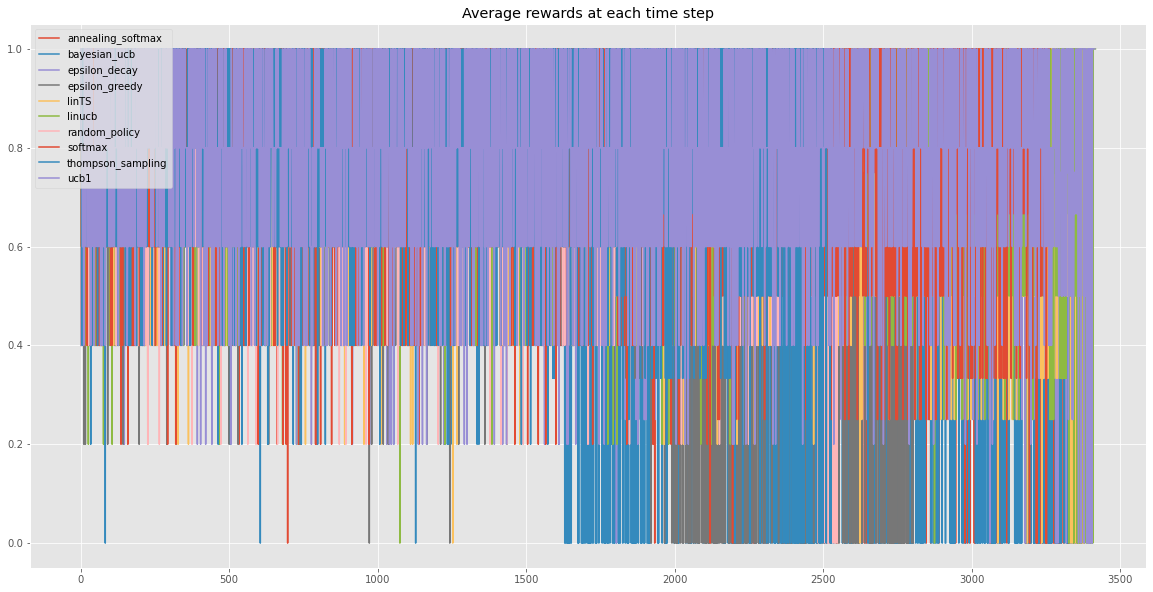

In [39]:
# Plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))

plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

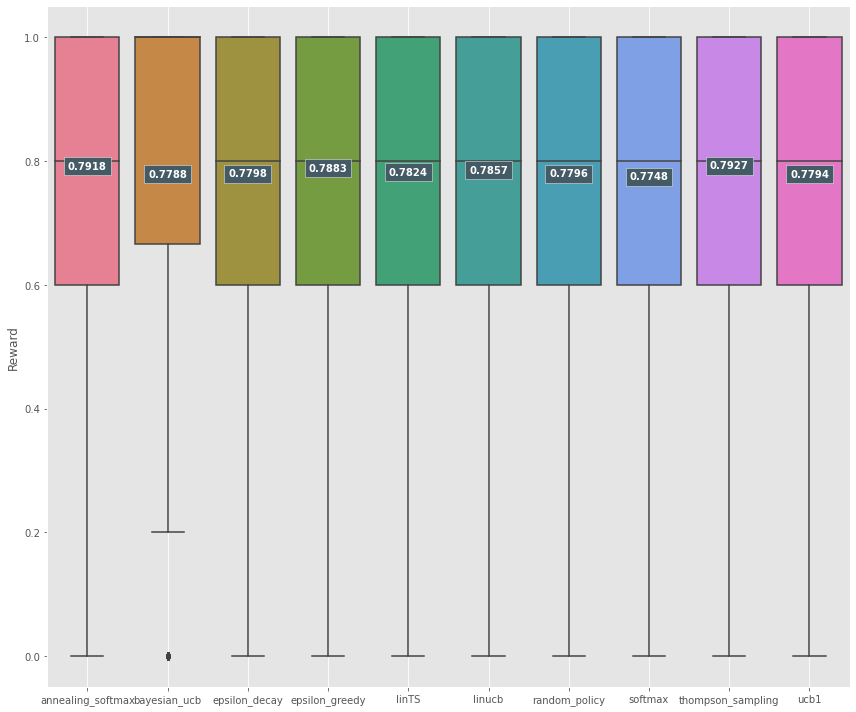

In [40]:
palette: str = "husl"
grouped: str = "policy"
default_value: str = "unknown"
target: str = "reward"

# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(df = final_evaluation_ber, column = grouped, palette = palette)

plot_multiple_boxplots(data=final_evaluation_ber,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

In [41]:
# Determine the cumulative reward at 1000 time step
final_evaluation_ber.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"}).sort_values(by=["cumulative_reward"], ascending = False)

,policy,cumulative_reward
5,linucb,2684.833333
0,annealing_softmax,2669.200000
9,ucb1,2661.816667
4,linTS,2646.716667
2,epsilon_decay,2618.633333
1,bayesian_ucb,2614.316667
7,softmax,2528.050000
3,epsilon_greedy,2210.450000
8,thompson_sampling,2003.233333
6,random_policy,1991.983333


Text(0.5, 1.0, 'Cumulative rewards at each step')

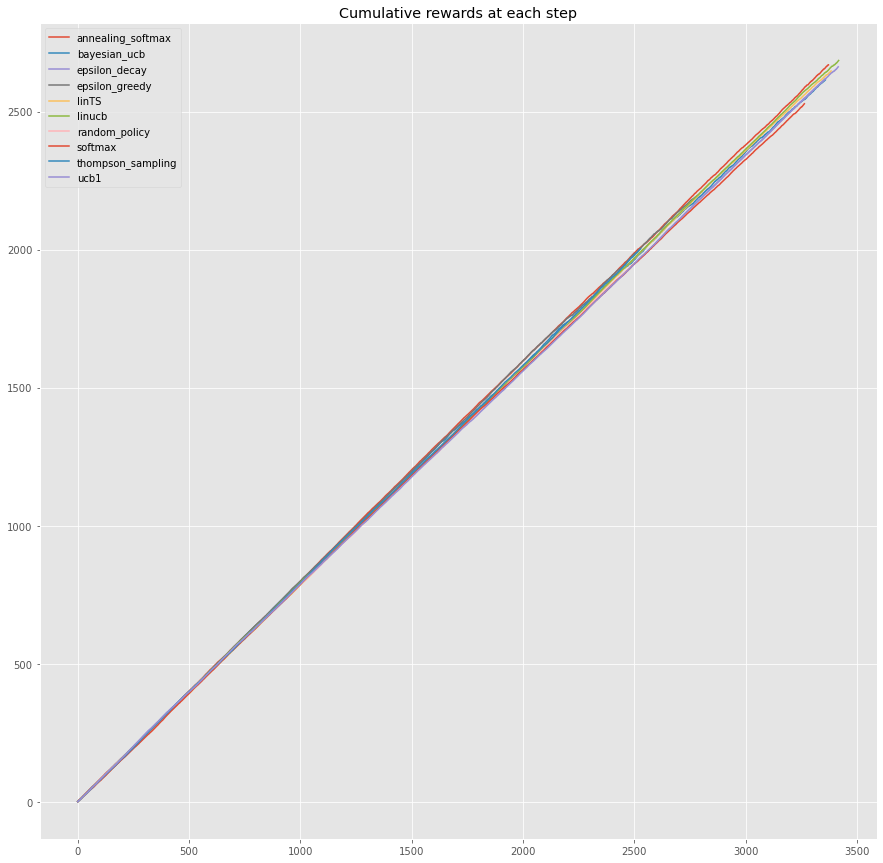

In [42]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

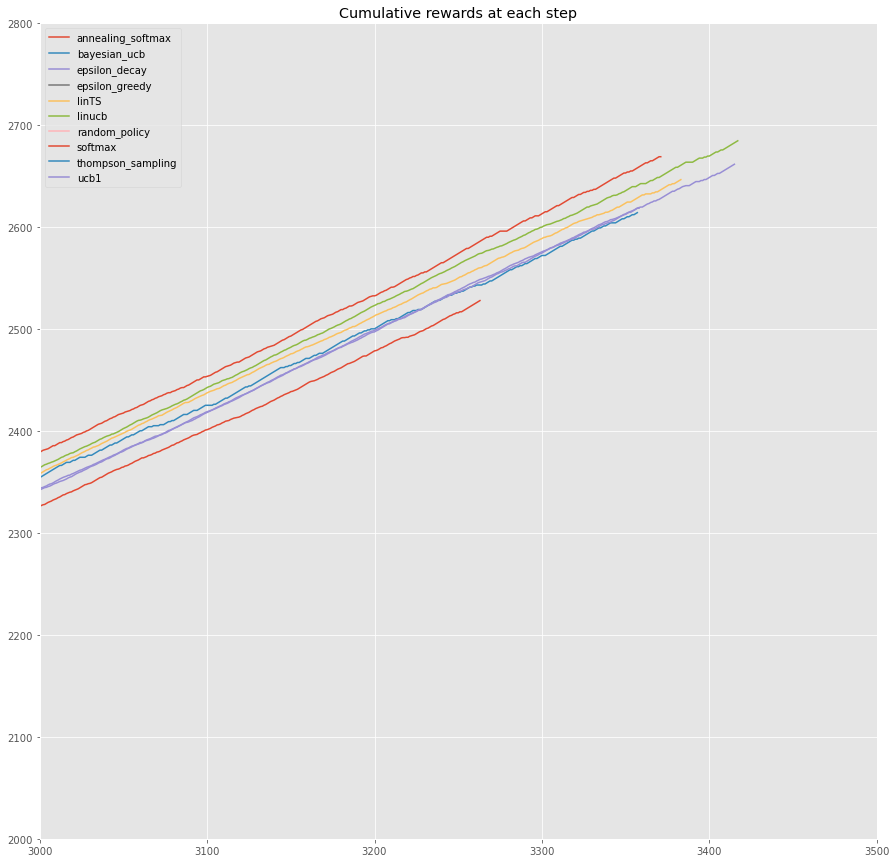

In [43]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.xlim(3000, 3500)
plt.ylim(2000, 2800)
plt.legend()
plt.title("Cumulative rewards at each step")

## Categorical Arm

In [44]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [random_policy, epsilon_decay, annealing_softmax, ucb1, epsilon_greedy, softmax, linucb, linTS]
# algos = [annealing_softmax]

# Define a dataframe for evaluation results
evaluation_cat = []

# Define a list to save all arm-play statistics
play_stats = []

count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1
    
    # Count samples
    sample_no = 0

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'mean', 'count', 'cat_dict', 'A', 'b', 'B', 'mu_hat', 'F']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'mean': 'float', 'count': 'float'})
        
        A = np.identity(2) # n_features = 2
        b = np.zeros(2)
        B = np.identity(2)
        mu_hat = np.zeros(2)
        F = np.zeros(2)
        
        # To keep track of categories count
        categories_dict = {'Dead': 0, 'Alive and still dependent': 0, 'Alive and recovered': 0, 'Alive with unknown status': 0}
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, categories_dict, A, b, B, mu_hat, F]
        
        step = 0
        sample_no += 1

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 5:
                rec_a = f(container, arms)
            elif count_algos >= 7:
                # Context (for contextual bandits) --> size = n_features
                context = np.array([bsample.iloc[i - 1]['AGE_new'], bsample.iloc[i - 1]['SEX_new']])
                rec_a = f(container, arms, context)
            else:
                rec_a = f(container, arms, 0.3)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (CAT)'] # get the reward value
                regret = 3 - reward
                category = bsample.iloc[i - 1]['REWARD_CATEGORICAL']
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm': action, 'time_step': step, 'sample': sample_no, 'sex': sex, 'age': age, 'reward': reward, 'regret': regret}
                evaluation_cat.append(eva_rec)
                
                # Update reward category
                container['cat_dict'][action - 1][category] = container['cat_dict'][action - 1][category] + 1
                new_estimated_prob = container['cat_dict'][action - 1][category] / sum(container['cat_dict'][action - 1].values())

                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['mean'] = np.where(container['arm'] == action, new_estimated_prob, container['mean'])
                if count_algos == 7:
                    container['A'][action - 1] = container['A'][action - 1] + np.outer(context, context)
                    container['b'][action - 1] = container['b'][action - 1] + new_estimated_prob * context
                if count_algos == 8:
                    container['B'][action - 1] = container['B'][action - 1] + context.dot(context.T)
                    container['F'][action - 1] = container['F'][action - 1] + new_estimated_prob * context
                    container['mu_hat'][action - 1] = np.linalg.inv(container['B'][action - 1]).dot(container['F'][action - 1])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [45]:
evaluation_cat = pd.DataFrame(evaluation_cat)
evaluation_cat_policy = evaluation_cat.sort_values(by=['policy','time_step'])
evaluation_cat_policy

,policy,chosen_arm,time_step,sample,sex,age,reward,regret
23649,annealing_softmax,3,1,1,M,OLD,3,0
26455,annealing_softmax,3,1,2,M,YOUNG,2,1
29150,annealing_softmax,2,1,3,F,OLD,3,0
31224,annealing_softmax,1,1,4,F,OLD,0,3
34049,annealing_softmax,4,1,5,F,OLD,2,1
...,...,...,...,...,...,...,...,...
46991,ucb1,1,3411,3,M,YOUNG,3,0
46992,ucb1,1,3412,3,F,YOUNG,3,0
46993,ucb1,1,3413,3,F,OLD,3,0
46994,ucb1,1,3414,3,M,OLD,3,0


In [46]:
final_evaluation_cat = evaluation_cat_policy.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                                           "regret":"mean"})

final_evaluation_cat['cumulative_reward'] = final_evaluation_cat.groupby(['policy'])['reward'].cumsum()
final_evaluation_cat['cumulative_regret'] = final_evaluation_cat.groupby(['policy'])['regret'].cumsum()
final_evaluation_cat

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,2.0,1.0,2.000000,1.000000
1,annealing_softmax,2,2.2,0.8,4.200000,1.800000
2,annealing_softmax,3,2.4,0.6,6.600000,2.400000
3,annealing_softmax,4,2.4,0.6,9.000000,3.000000
4,annealing_softmax,5,2.2,0.8,11.200000,3.800000
...,...,...,...,...,...,...
23099,ucb1,3411,3.0,0.0,6528.383333,3704.616667
23100,ucb1,3412,3.0,0.0,6531.383333,3704.616667
23101,ucb1,3413,3.0,0.0,6534.383333,3704.616667
23102,ucb1,3414,3.0,0.0,6537.383333,3704.616667


In [47]:
evaluation_cat_treatment = evaluation_cat.sort_values(by=['policy', 'sample', 'time_step'])
evaluation_cat_treatment_F = evaluation_cat_treatment[evaluation_cat_treatment['sex'] == 'F']
evaluation_cat_treatment_M = evaluation_cat_treatment[evaluation_cat_treatment['sex'] == 'M']
evaluation_cat_treatment_Y = evaluation_cat_treatment[evaluation_cat_treatment['age'] == 'YOUNG']
evaluation_cat_treatment_O = evaluation_cat_treatment[evaluation_cat_treatment['age'] == 'OLD']

In [48]:
evaluation_cat_best_treatment = evaluation_cat_treatment.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})


In [49]:
evaluation_cat_best_treatment = evaluation_cat_best_treatment.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                            "regret":"mean"})
evaluation_cat_best_treatment

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,1.918379,1.081621
1,annealing_softmax,2,1.984088,1.015912
2,annealing_softmax,3,1.950483,1.049517
3,annealing_softmax,4,2.070154,0.929846
4,epsilon_decay,1,1.927706,1.072294
5,epsilon_decay,2,1.992633,1.007367
6,epsilon_decay,3,1.922677,1.077323
7,epsilon_decay,4,2.042811,0.957189
8,epsilon_greedy,1,1.938836,1.061164
9,epsilon_greedy,2,2.006943,0.993057


In [50]:
evaluation_cat_groupedtreatment_F = evaluation_cat_treatment_F.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [51]:
evaluation_cat_groupedtreatment_F = evaluation_cat_groupedtreatment_F.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_F

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,1.764491,1.235509
1,annealing_softmax,2,1.897869,1.102131
2,annealing_softmax,3,1.764239,1.235761
3,annealing_softmax,4,1.980148,1.019852
4,epsilon_decay,1,1.773711,1.226289
5,epsilon_decay,2,1.904136,1.095864
6,epsilon_decay,3,1.770073,1.229927
7,epsilon_decay,4,1.970125,1.029875
8,epsilon_greedy,1,1.771158,1.228842
9,epsilon_greedy,2,1.901936,1.098064


In [52]:
evaluation_cat_groupedtreatment_M = evaluation_cat_treatment_M.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [53]:
evaluation_cat_groupedtreatment_M = evaluation_cat_groupedtreatment_M.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_M

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,2.052909,0.947091
1,annealing_softmax,2,2.069466,0.930534
2,annealing_softmax,3,2.117796,0.882204
3,annealing_softmax,4,2.121940,0.878060
4,epsilon_decay,1,2.058979,0.941021
5,epsilon_decay,2,2.086968,0.913032
6,epsilon_decay,3,2.052755,0.947245
7,epsilon_decay,4,2.094269,0.905731
8,epsilon_greedy,1,2.074666,0.925334
9,epsilon_greedy,2,2.110564,0.889436


In [54]:
evaluation_cat_groupedtreatment_Y = evaluation_cat_treatment_Y.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [55]:
evaluation_cat_groupedtreatment_Y = evaluation_cat_groupedtreatment_Y.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_Y

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,2.342835,0.657165
1,annealing_softmax,2,2.281699,0.718301
2,annealing_softmax,3,2.297413,0.702587
3,annealing_softmax,4,2.277165,0.722835
4,epsilon_decay,1,2.372707,0.627293
5,epsilon_decay,2,2.290785,0.709215
6,epsilon_decay,3,2.222348,0.777652
7,epsilon_decay,4,2.280182,0.719818
8,epsilon_greedy,1,2.357652,0.642348
9,epsilon_greedy,2,2.318065,0.681935


In [56]:
evaluation_cat_groupedtreatment_O = evaluation_cat_treatment_O.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [57]:
evaluation_cat_groupedtreatment_O = evaluation_cat_groupedtreatment_O.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_O

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,1.671014,1.328986
1,annealing_softmax,2,1.758852,1.241148
2,annealing_softmax,3,1.739915,1.260085
3,annealing_softmax,4,1.934961,1.065039
4,epsilon_decay,1,1.664184,1.335816
5,epsilon_decay,2,1.794451,1.205549
6,epsilon_decay,3,1.735527,1.264473
7,epsilon_decay,4,1.900163,1.099837
8,epsilon_greedy,1,1.686731,1.313269
9,epsilon_greedy,2,1.805338,1.194662


## Test Stats

### Comparing between Algorithms
Is there a difference in performance between the different multi-armed bandit algorithms?

In [58]:
epsilon_greedy_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'ucb1']['reward'])
linucb_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'linucb']['reward'])
lints_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'linTS']['reward'])

kruskal(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, linucb_rewards, lints_rewards)

KruskalResult(statistic=21.09552810217735, pvalue=0.0017634969536030934)

In [80]:
tukey_df_algo_cat = final_evaluation_cat[['policy', 'reward']]
tukey_df_algo_cat = tukey_df_algo_cat.groupby(['policy'], as_index = False).aggregate({"reward":"mean"})

dunn_cat = sp.posthoc_dunn(tukey_df_algo_cat, val_col = 'reward', group_col = 'policy')

dunn_cat_export = dunn_cat.copy()

def highlight_cell(cell_value):
    if cell_value < 0.05:
        return "background-color: lightgreen"

dunn_cat = dunn_cat.style.applymap(highlight_cell)
dfi.export(dunn_cat, 'categorical_dunn.png')
dunn_cat

C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe


,annealing_softmax,epsilon_decay,epsilon_greedy,linTS,linucb,random_policy,softmax,ucb1
annealing_softmax,1.000000,0.083265,0.248213,0.386476,0.563703,0.772830,0.148915,0.772830
epsilon_decay,0.083265,1.000000,0.563703,0.386476,0.248213,0.148915,0.772830,0.043308
epsilon_greedy,0.248213,0.563703,1.000000,0.772830,0.563703,0.386476,0.772830,0.148915
linTS,0.386476,0.386476,0.772830,1.000000,0.772830,0.563703,0.563703,0.248213
linucb,0.563703,0.248213,0.563703,0.772830,1.000000,0.772830,0.386476,0.386476
random_policy,0.772830,0.148915,0.386476,0.563703,0.772830,1.000000,0.248213,0.563703
softmax,0.148915,0.772830,0.772830,0.563703,0.386476,0.248213,1.000000,0.083265
ucb1,0.772830,0.043308,0.148915,0.248213,0.386476,0.563703,0.083265,1.000000


In [81]:
dunn_cat_export = dunn_cat_export[["epsilon_decay"]]
dunn_cat_export = dunn_cat_export.style.applymap(highlight_cell)
dfi.export(dunn_cat_export, 'categorical_selected_dunn.png')
dunn_cat_export

C:\Program Files (x86)\Google\Chrome\Application\chrome.exe


,epsilon_decay
annealing_softmax,0.083265
epsilon_decay,1.000000
epsilon_greedy,0.563703
linTS,0.386476
linucb,0.248213
random_policy,0.148915
softmax,0.772830
ucb1,0.043308


In [60]:
# f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
#          ucb1_rewards, linucb_rewards, lints_rewards)

# tukey_algo_cat = pairwise_tukeyhsd(endog=tukey_df_algo_cat['reward'],
#                                    groups=tukey_df_algo_cat['policy'],
#                                    alpha=0.05)

# print(tukey_algo_cat)

### Comparing for Treatments 
For each treatment method, is there a difference in performance between different age groups or different sex?


In [61]:
evaluation_cat_groupedtreatment_F1 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_F2 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_F3 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_F4 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 4]

evaluation_cat_groupedtreatment_M1 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_M2 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_M3 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_M4 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 4]

In [62]:
sex_1 = ttest_ind(evaluation_cat_groupedtreatment_F1['reward'], evaluation_cat_groupedtreatment_M1['reward'])
sex_2 = ttest_ind(evaluation_cat_groupedtreatment_F2['reward'], evaluation_cat_groupedtreatment_M2['reward'])
sex_3 = ttest_ind(evaluation_cat_groupedtreatment_F3['reward'], evaluation_cat_groupedtreatment_M3['reward'])
sex_4 = ttest_ind(evaluation_cat_groupedtreatment_F4['reward'], evaluation_cat_groupedtreatment_M4['reward'])
print(f'Treatment 1 (sex): {sex_1}')
print(f'Treatment 2 (sex): {sex_2}')
print(f'Treatment 3 (sex): {sex_3}')
print(f'Treatment 4 (sex): {sex_4}')

Treatment 1 (sex): Ttest_indResult(statistic=-3.982656537392128, pvalue=0.0013615933528128227)
Treatment 2 (sex): Ttest_indResult(statistic=-1.7411916996734127, pvalue=0.10524665082866695)
Treatment 3 (sex): Ttest_indResult(statistic=-3.0836924446122977, pvalue=0.009472700958700703)
Treatment 4 (sex): Ttest_indResult(statistic=-4.2101866502730365, pvalue=0.0014603063903920967)


In [63]:
evaluation_cat_groupedtreatment_Y1 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_Y2 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_Y3 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_Y4 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 4]

evaluation_cat_groupedtreatment_O1 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_O2 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_O3 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_O4 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 4]

In [64]:
age_1 = ttest_ind(evaluation_cat_groupedtreatment_Y1['reward'], evaluation_cat_groupedtreatment_O1['reward'])
age_2 = ttest_ind(evaluation_cat_groupedtreatment_Y2['reward'], evaluation_cat_groupedtreatment_O2['reward'])
age_3 = ttest_ind(evaluation_cat_groupedtreatment_Y3['reward'], evaluation_cat_groupedtreatment_O3['reward'])
age_4 = ttest_ind(evaluation_cat_groupedtreatment_Y4['reward'], evaluation_cat_groupedtreatment_O4['reward'])
print(f'Treatment 1 (age): {age_1}')
print(f'Treatment 2 (age): {age_2}')
print(f'Treatment 3 (age): {age_3}')
print(f'Treatment 4 (age): {age_4}')

Treatment 1 (age): Ttest_indResult(statistic=51.057734826201724, pvalue=2.6055340937050986e-17)
Treatment 2 (age): Ttest_indResult(statistic=11.062247949575475, pvalue=1.1907932680107341e-07)
Treatment 3 (age): Ttest_indResult(statistic=3.5098112438513387, pvalue=0.004303402394370081)
Treatment 4 (age): Ttest_indResult(statistic=5.089478424320902, pvalue=0.0002664198112964526)


## Reward

Text(0.5, 1.0, 'Average rewards at each time step')

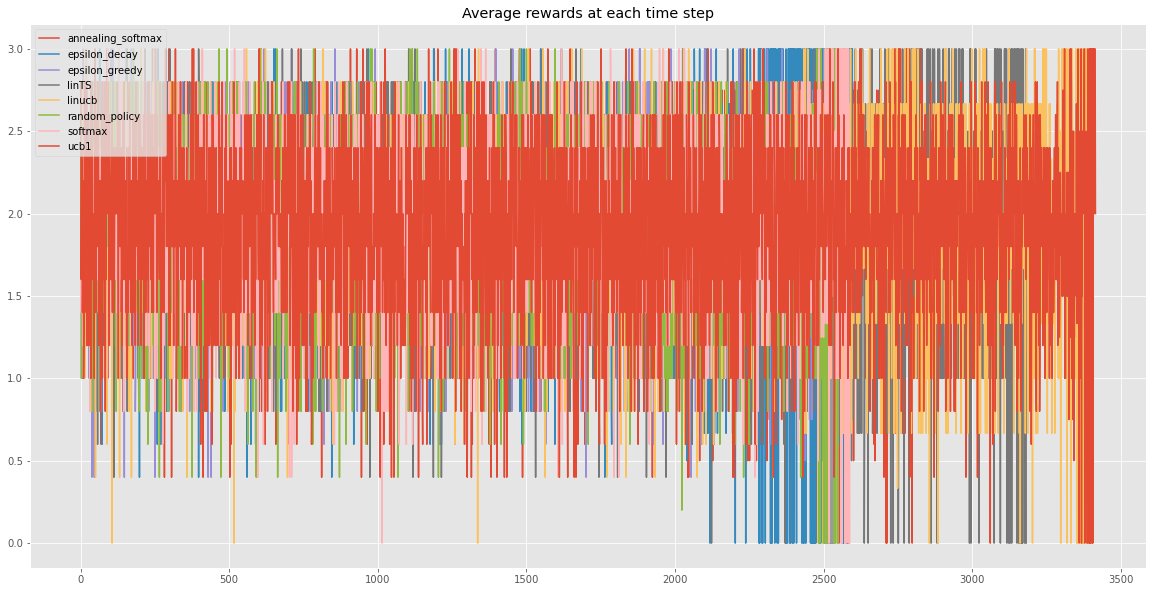

In [65]:
# Plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))
plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

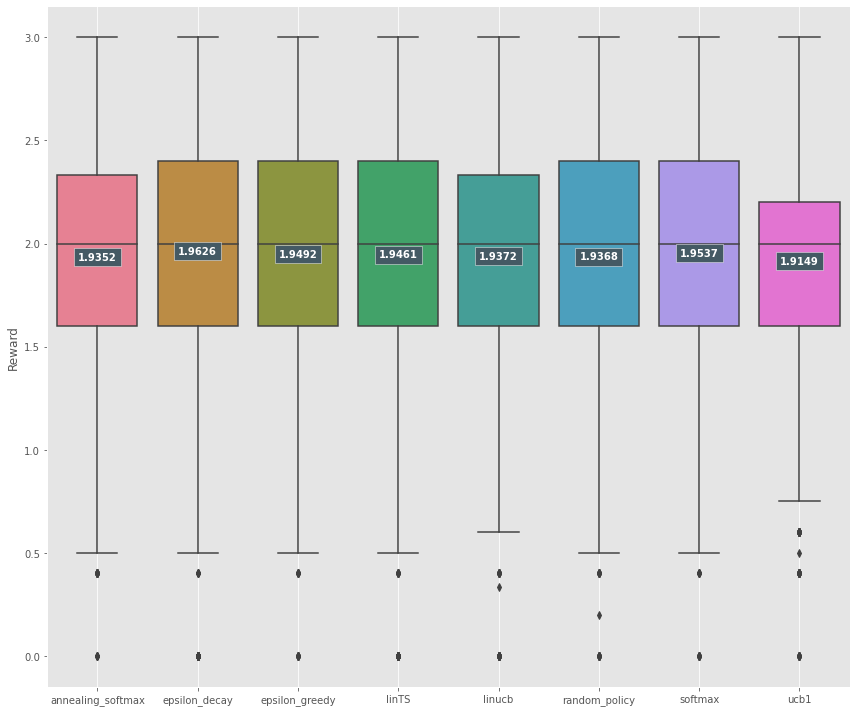

In [66]:
palette: str = "husl"
grouped: str = "policy"
default_value: str = "unknown"
target: str = "reward"

# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(df = final_evaluation_cat, column = grouped, palette = palette)

plot_multiple_boxplots(data=final_evaluation_cat,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

In [67]:
# Determine the cumulative reward at 1000 time step
final_evaluation_cat.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"}).sort_values(by=["cumulative_reward"], ascending = False)

,policy,cumulative_reward
4,linucb,6572.866667
7,ucb1,6539.383333
3,linTS,6192.533333
0,annealing_softmax,5474.816667
1,epsilon_decay,5096.833333
6,softmax,5056.083333
2,epsilon_greedy,4960.600000
5,random_policy,4948.550000


Text(0.5, 1.0, 'Cumulative rewards at each step')

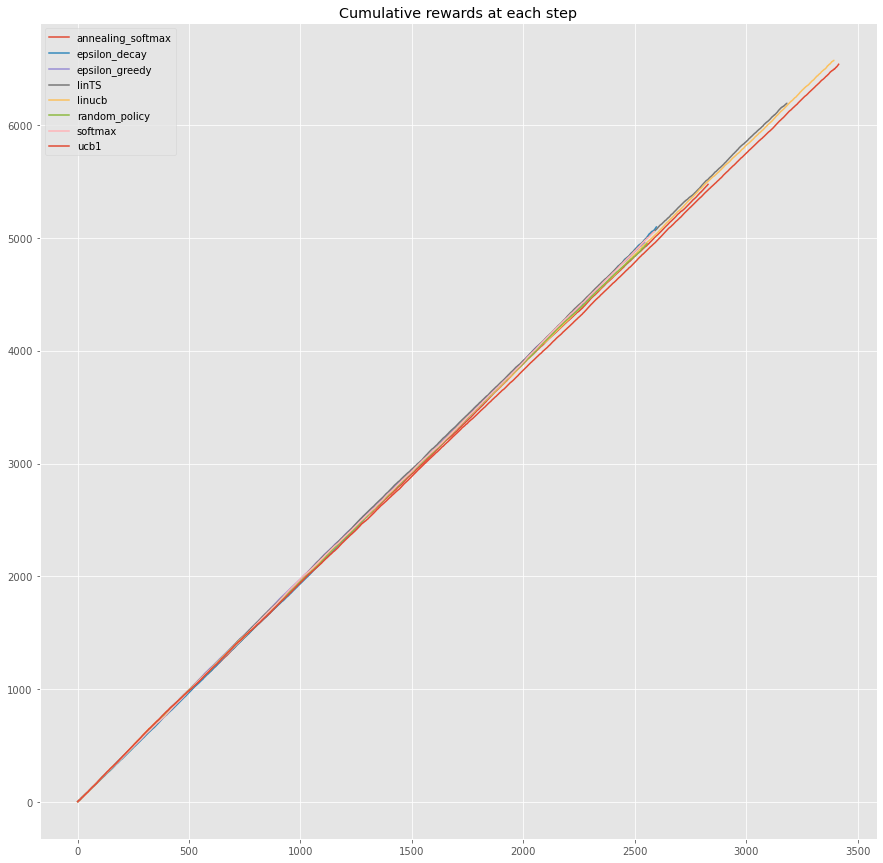

In [68]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

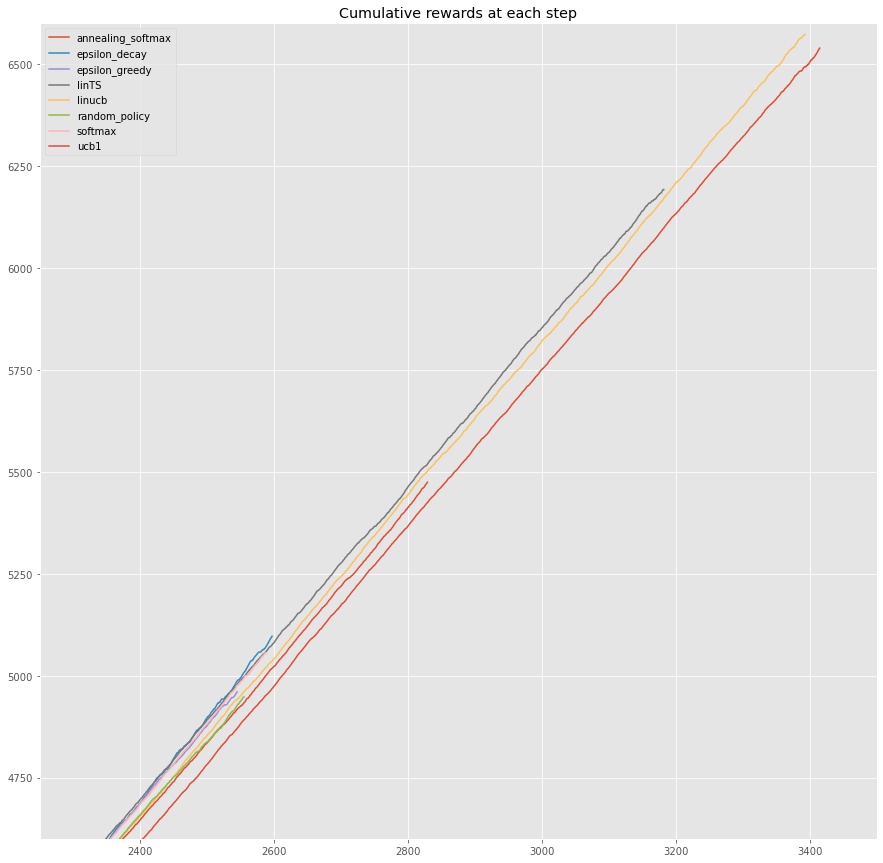

In [70]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))
    
plt.xlim(2250, 3500)
plt.ylim(4600, 6600)
plt.legend()
plt.title("Cumulative rewards at each step")